# Fitting Sersic profiles to galaxies in a Hubble image

Here we use Astropy Sersic2D to model every object detected in a public HST image:  
CLASH WFC3/IR F160W imaging of the galaxy cluster MACS0647+70
  
It's like a quick and dirty version of GALFIT. Note we're fitting all objects, including stars, each with individual Sersic profile. The Sersic fitting of each galaxy is performed in multiple steps to make it more stable. Otherwise, it's not very fancy.

Inputs:  
- HST FITS image (retrieved from MAST online archive)
- segmentation map (defining the outline of each object; here we use a version manually cleaned of artifacts)
- object catalog (here from Astropy Photutils)

Outputs:  
- Sersic model catalog
- model FITS image

In [1]:
interactive_plots = False

if interactive_plots:
    %matplotlib notebook
    figsize=(9.5,3)
else:
    %matplotlib inline
    figsize=(15,5)

import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import astropy
from astropy.io import fits
from astropy import units as u
from astropy.table import QTable

import photutils

In [3]:
import numpy as np
import scipy.special as sp

In [4]:
from glob import glob
import os

In [5]:
# Load HST WFC3/IR F160W image
image_file = 'https://archive.stsci.edu/missions/hlsp/clash/macs0647/data/hst/scale_65mas/hlsp_clash_hst_wfc3ir_macs0647_f160w_v1_drz.fits'
hdu   = fits.open(image_file)[0]
data_count_rate  = hdu.data
exposure_time = hdu.header['EXPTIME']
data_counts = data_count_rate * exposure_time  # convert from counts/s to counts

In [6]:
def HST_zeropoint(header, force_per_second=False, force_total=False):
    photflam = header.get('PHOTFLAM', None)  # inverse sensitivity (erg / cm^2 / s / Ang)
    photplam = header.get('PHOTPLAM', None)  # pivot wavelength
    photplam0 = 5475.4
    pzpt     = header.get('PHOTZPT')
    exptime  = header.get('EXPTIME')
    bunit    = header.get('BUNIT', 'COUNTS')
    bunit    = bunit.strip()
    if ((bunit[-2:] != '/S') or (force_total == True)) and (force_per_second == False):
        photflam = photflam / exptime
    
    zp = pzpt - 2.5 * np.log10(photflam) - 5 * np.log10(photplam / photplam0)
    return zp

In [7]:
# flux = zp - 2.5 * log10(mag)
zeropoint = HST_zeropoint(hdu.header)
zeropoint

25.955899912844764

In [8]:
import os
from os.path import expanduser
home = expanduser("~")
catalog_path = os.path.join(home, 'm0647', 'Ryan')

In [9]:
# Load cleaned segmentation map (from Russ)
segm_file = os.path.join(catalog_path, 'z11_seg_cleaned.fits')
segmhdu = fits.open(segm_file)[0]
segm_data = segmhdu.data
segm = photutils.segmentation.SegmentationImage(segm_data)

In [10]:
# Input photutils catalog
catalog_file = os.path.join(catalog_path, 'MACS0647.ecsv')

tbl = QTable.read(catalog_file)
tbl['ra']  = tbl['sky_centroid'].ra.degree
tbl['dec'] = tbl['sky_centroid'].dec.degree
tbl.remove_column('sky_centroid')  # can't be sorted!
tbl.sort('F160W_mag')

In [11]:
from astropy.modeling import models, fitting
from astropy.modeling.models import Sersic2D, Sersic1D
fitter = fitting.LevMarLSQFitter()
#import warnings

In [12]:
from astropy.visualization import LinearStretch, SqrtStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import simple_norm
#norm = ImageNormalize(stretch=LinearStretch(), vmin=-0.1)
#norm = ImageNormalize(stretch=SqrtStretch())

(2000, 3000)

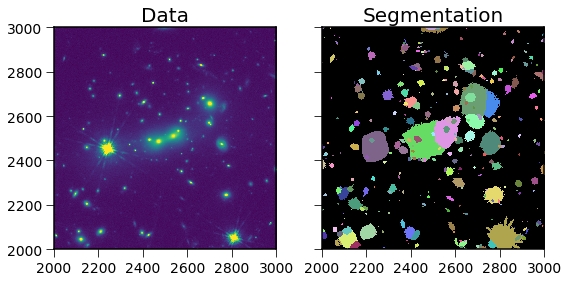

In [13]:
# Format interactive cursor output for segmentation map (otherwise 4-digit integers truncated in output)

plot_data0 = data_count_rate
def format_coord0(x, y):
    col = int(x + 0.5)
    row = int(y + 0.5)
    z = plot_data0[row, col]
    return 'x=%d, y=%d, data=%d' % (col, row, z)

plot_data = segm_data  #segm.data #[segmobj.bbox.slices]
def format_coord1(x, y):
    col = int(x + 0.5)
    row = int(y + 0.5)
    z = plot_data[row, col]
    return 'x=%d, y=%d, segm=%d' % (col, row, z)

fig, ax = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)

ax[0].set_title('Data')
norm = simple_norm(data_count_rate, 'asinh', percent=99.9)
ax[0].imshow(data_count_rate, norm=norm)
ax[0].format_coord = format_coord0

ax[1].set_title('Segmentation')
cmap = segm.make_cmap(random_state=12345)  # ERROR
ax[1].imshow(segm_data, cmap=cmap)
ax[1].format_coord = format_coord1

plt.xlim(2000,3000)
plt.ylim(2000,3000)

#plt.savefig('HST_Sersic_fitting.png', dpi=200)

In [14]:
maxiter = 10000  # maximum number of iterations  1000000

In [15]:
n_0 = 1  # initial guess for n_Sersic
n_min = 0.25  # minimum allowed
n_max = 8     # maximum allowed

def initial_guess_from_catalog(tbl_obj):
    x = tbl_obj['xcentroid'].value
    y = tbl_obj['ycentroid'].value
    a = tbl_obj['a'].value
    b = tbl_obj['b'].value
    A = tbl_obj['area']  # ~ pi r^2
    r_Sersic = np.sqrt(A / np.pi).value
    n_Sersic = n_0
    ellipticity    = tbl_obj['ellipticity']
    position_angle = tbl_obj['orientation']
    theta = position_angle.to(u.rad)
    magnitude = tbl[iobj]['F160W_mag']
    flux = zeropoint - 2.5 * np.log10(magnitude)
    flux *= exposure_time
    #count_rate = magnitude_to_countrate('imaging', 'abmag', magnitude, photfnu)    
    b_n = sp.gammaincinv(2*n_Sersic, 0.5)
    Sersic_total = 2 * np.pi * a * b * n_Sersic * sp.gamma(2 * n_Sersic) * np.exp(b_n) / \
        (b_n**(2*n_Sersic))
    amplitude = 1 / Sersic_total
    amplitude *= flux
    
    initial_guess = Sersic2D(amplitude=amplitude, r_eff=r_Sersic, x_0=x, y_0=y, ellip=ellipticity, theta=theta, n=n_0, bounds=param_bounds, fixed=param_fixed)
    #print(initial_guess.render)
    return initial_guess

In [16]:
def initial_guess_from_model(model):
    #global initial_guess
    initial_guess = Sersic2D(amplitude=model.amplitude, r_eff=model.r_eff, x_0=model.x_0, y_0=model.y_0, ellip=model.ellip, theta=model.theta, n=model.n, bounds=param_bounds, fixed=param_fixed)
    #print(initial_guess)
    return initial_guess    

In [17]:
def fit_model_to_data(plot_results=True, verbose=False):
    global model, norm, fit_stamp, fitter
    model = fitter(initial_guess, xx_stamp, yy_stamp, data_stamp, weights=weight_stamp, maxiter=maxiter)
    #print(model)
    if verbose:
        print(fitter.fit_info['message'])
        print(model.render)
    fit_stamp = model(xx_stamp, yy_stamp).value
    #fit_stamp = np.ma.masked_array(fit_stamp, segm_obj.data_ma.mask)
    return

In [18]:
def plot_fit_results(outfile=''):
    global norm, ax
    #norm = ImageNormalize(stretch=LinearStretch()) #, vmin=-0.1)
    #norm = ImageNormalize(stretch=SqrtStretch())
    norm = ImageNormalize(stretch=LogStretch())
    extent = stamp_extent
    
    fig, ax = plt.subplots(1, 4, figsize=figsize, sharex=True, sharey=True)

    ax[0].imshow(data_stamp, norm=norm, vmin=0, extent=extent)
    ax[0].set_title('Data')

    ax[1].imshow(fit_stamp, norm=norm, vmin=0, extent=extent)
    ax[1].set_title('Fit')

    residual = fit_stamp - data_stamp
    ax[2].imshow(np.abs(residual), norm=norm, vmin=0, extent=extent)
    ax[2].set_title('abs(Residual)')

    ax[3].imshow(residual, extent=extent, cmap='bwr')
    ax[3].set_title('Residual')
    
    if outfile:
        plt.savefig(outfile)
        plt.close()
    else:
        plt.show()

In [19]:
def plot_fit_results2(outfile=''):
    global norm, ax
    #norm = ImageNormalize(stretch=LinearStretch()) #, vmin=-0.1)
    #norm = ImageNormalize(stretch=SqrtStretch())
    norm = ImageNormalize(stretch=LogStretch())
    extent = stamp_extent
    
    fig, ax = plt.subplots(1, 5, figsize=figsize, sharex=True, sharey=True)

    ax[0].imshow(data_stamp, norm=norm, vmin=0, extent=extent)
    ax[0].set_title('Data')

    ax[1].imshow(fit_stamp, norm=norm, vmin=0, extent=extent)
    ax[1].set_title('Fit')

    residual = fit_stamp - data_stamp
    ax[2].imshow(np.abs(residual), norm=norm, vmin=0, extent=extent)
    ax[2].set_title('abs(Residual)')

    ax[3].imshow(residual, extent=extent, cmap='bwr')
    ax[3].set_title('Residual')
    
    ax[4].imshow(weight_stamp**2, extent=extent)
    ax[4].set_title('Weight^2')
    
    if outfile:
        plt.savefig(outfile)
        plt.close()
    else:
        plt.show()

In [20]:
#plot_fit_results2()

In [21]:
rmax = 50

def keep_close(x, goal, dist):
    d = x - goal
    dabs = abs(d)
    if dabs:
        sgn = int(d / dabs)
        if dabs > dist:
            x = goal + sgn * dist
    return x

In [22]:
data_min = 10  # for use with weight map calculation

In [23]:
def fit_object_to_Sersic(segm_id):
    global iobj, segm_obj, tbl_obj, data_stamp, weight_stamp, stamp_extent, xx_stamp, yy_stamp, \
        param_bounds, param_fixed, initial_guess, model
    
    iobj = segm.get_index(segm_id)
    segm_obj = segm[iobj]
    #tbl_obj  = tbl[iobj]
    tbl_obj = tbl[tbl['id'].data == segm_id]
    x = tbl_obj['xcentroid'].value
    y = tbl_obj['ycentroid'].value

    yslice_obj, xslice_obj = obj_slices = segm_obj.slices
    ymin_obj = yslice_obj.start
    ymax_obj = yslice_obj.stop - 1
    xmin_obj = xslice_obj.start
    xmax_obj = xslice_obj.stop - 1
    #print('***', ymin_obj, ymax_obj+1, xmin_obj, xmax_obj+1, y, x)

    xmin_stamp = keep_close(xmin_obj, int(x), rmax)
    xmax_stamp = keep_close(xmax_obj, int(x), rmax)
    ymin_stamp = keep_close(ymin_obj, int(y), rmax)
    ymax_stamp = keep_close(ymax_obj, int(y), rmax)
    #print('***', ymin_stamp, ymax_stamp+1, xmin_stamp, xmax_stamp+1, y, x)

    yy_obj, xx_obj = np.mgrid[segm_obj.slices]
    xy_within_stamp = (xmin_stamp <= xx_obj) & (xx_obj <= xmax_stamp) \
                    & (ymin_stamp <= yy_obj) & (yy_obj <= ymax_stamp)
    #xy_outside_stamp = np.logical_not(xy_within_stamp)

    data_within_obj = np.logical_not(segm_obj.data_ma.mask)
    all_good = data_within_obj & xy_within_stamp
    obj_mask = np.logical_not(all_good)
    data_obj = np.ma.masked_array(segm_obj.make_cutout(data_counts), obj_mask)
    yy_stamp, xx_stamp = np.mgrid[ymin_stamp:ymax_stamp+1, xmin_stamp:xmax_stamp+1]

    xstamp_slice = slice(xmin_stamp-xmin_obj, xmax_stamp-xmin_obj+1)
    ystamp_slice = slice(ymin_stamp-ymin_obj, ymax_stamp-ymin_obj+1)
    data_stamp = data_obj[ystamp_slice,xstamp_slice]
    data_stamp_clipped = np.where(data_stamp < data_min, data_min, data_stamp)
    weight_stamp = np.sqrt(data_stamp_clipped)
    weight_stamp = np.where(data_stamp.mask, 0, weight_stamp)
    stamp_extent = xmin_stamp-0.5, xmax_stamp+0.5, ymin_stamp-0.5, ymax_stamp+0.5

    param_bounds = {}
    param_fixed = {}
    
    # Initial guess based on photutils catalog
    initial_guess = initial_guess_from_catalog(tbl_obj)
    model = initial_guess
    fit_stamp = model(xx_stamp, yy_stamp).value
    #fit_stamp = np.ma.masked_array(fit_fit_stampobj, segm_obj.data_ma.mask)
    
    # Restrict effective radius to within object
    r_eff_max = np.max([(xmax_obj-xmin_obj)/2, (ymax_obj-ymin_obj)/2])
    
    # Model #1: Set amplitude free
    param_bounds = {'ellip':(0,1), 'n':(n_min,n_max), 'theta':(0,2*np.pi), 'r_eff':(0,r_eff_max), 'x_0':(xmin_stamp,xmax_stamp), 'y_0':(ymin_stamp,ymax_stamp)}
    param_fixed = {'r_eff':True, 'ellip':True, 'n':True, 'theta':True, 'x_0':True, 'y_0':True}
    initial_guess = initial_guess_from_model(model)  # run this again to set bounds/fixed constraints above
    fit_model_to_data()  # verbose=True

    # Model #2: Fit amplitude & radius
    param_bounds = {'ellip':(0,1), 'n':(n_min,n_max), 'theta':(0,2*np.pi), 'r_eff':(0,r_eff_max), 'x_0':(xmin_stamp,xmax_stamp), 'y_0':(ymin_stamp,ymax_stamp)}
    param_fixed = {'ellip':True, 'n':True, 'theta':True, 'x_0':True, 'y_0':True}
    initial_guess = initial_guess_from_model(model)
    fit_model_to_data()
    
    # Model #3: Fit amplitude, radius, & centroid
    param_fixed = {'ellip':True, 'theta':True, 'r_eff':True}
    initial_guess = initial_guess_from_model(model)
    fit_model_to_data()
    
    # Model #4: Fit everything but theta
    param_fixed = {'theta':True}
    initial_guess = initial_guess_from_model(model)
    fit_model_to_data()

In [24]:
def Sersic_galaxy(model, floor=None):
    model1D = Sersic1D(amplitude=model.amplitude, r_eff=model.r_eff, n=model.n)
    radius_factor = 3
    stamp_radius = radius_factor * model.r_eff
    test_amplitude = model1D(stamp_radius)
    if floor != None:
        while test_amplitude > floor:
            radius_factor *= 1.1
            stamp_radius = radius_factor * model.r_eff
            test_amplitude = model1D(stamp_radius)
            #print(radius_factor, test_radius, test_amplitude)
            if stamp_radius > image_size:
                break
    
    #print('%4d %6.1f %6.1f  %g' % (iobj, radius_factor, test_radius, test_amplitude))
    #s = '%4d  %4d  %10.3g %4d %4d  %g' % (iobj, id, model.amplitude, radius_factor, stamp_radius, test_amplitude)
    s = '%4d  %11.4g %4d %4d  %g' % (segm_id, model.amplitude.value, radius_factor, stamp_radius, test_amplitude)
    #print(s)
    #fout.write(s+'\n')
    
    xmin = int(model.x_0 - stamp_radius)
    xmax = int(model.x_0 + stamp_radius + 1)
    ymin = int(model.y_0 - stamp_radius)
    ymax = int(model.y_0 + stamp_radius + 1)
    x_stamp, y_stamp = np.meshgrid(np.arange(xmin, xmax), np.arange(ymin, ymax))
    
    stamp = model(x_stamp, y_stamp)
    stamp = stamp.value
    extent = xmin, xmax, ymin, ymax
    return stamp, extent

In [25]:
def add_stamp_to_image(image, stamp, extent):
    xmin, xmax, ymin, ymax = extent
    stamp_within_image = stamp[:]
    stamp_ylo = stamp_xlo = 0
    stamp_yhi, stamp_xhi = stamp.shape
    
    if ymin < 0:
        stamp_ylo -= ymin
        stamp_yhi -= stamp_ylo
        ymin = 0
        ymax -= stamp_ylo
    if ymax > ny_image:
        stamp_yhi -= (ymax - ny_image)
        ymax = ny_image
    if xmin < 0:
        stamp_xlo -= xmin
        stamp_xhi -= stamp_xlo
        xmin = 0
        xmax -= stamp_xlo
    if xmax > nx_image:
        stamp_xhi -= (xmax - nx_image)
        xmax = nx_image
        
    stamp_within_image = stamp[stamp_ylo:stamp_yhi, stamp_xlo:stamp_xhi]
    
    image[ymin:ymax, xmin:xmax] += stamp_within_image
    return image

In [26]:
def show_fit(outfile=''):
    fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)

    ax[0].set_title('Data')
    norm = simple_norm(data_counts, 'asinh', percent=99.9)
    ax[0].imshow(data_counts, norm=norm)

    ax[1].set_title('Masked Data')
    ax[1].imshow(data_counts_masked, norm=norm)

    ax[2].set_title('Model')
    ax[2].imshow(image, norm=norm)

    plt.xlim(2000,3000)
    plt.ylim(2000,3000)
    if outfile:
        plt.savefig(outfile)
        plt.close()
    else:
        plt.show()

In [27]:
segm_id = 786
#segm_id = 286  # BCG
#segm_id = 425  # BCG
segm_id = 16 # bright star requires weights = data (or maybe a smaller stamp!)
segm_id = 782
#segm_id = 17  # requires more weighting in the center
#segm_id = 1536 # spiral

# Long arcs:
segm_id = tbl['id'][278]

fit_object_to_Sersic(segm_id)
#plot_fit_results()

In [28]:
tbl

id,xcentroid,ycentroid,area,a,b,ellipticity,orientation,gini,F105W_flux,F105W_fluxerr,F105W_mag,F105W_magerr,F125W_flux,F125W_fluxerr,F125W_mag,F125W_magerr,F140W_flux,F140W_fluxerr,F140W_mag,F140W_magerr,F160W_flux,F160W_fluxerr,F160W_mag,F160W_magerr,TOTAL_flux,TOTAL_fluxerr,TOTAL_mag,TOTAL_magerr,ra,dec
,pix,pix,pix2,pix,pix,,deg,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,nJy,nJy,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
16,2347.9284951456048,1674.4920495695358,56428.0,10.102895784793382,9.926894783407528,0.017420846966546666,-66.39695975129004,0.9809265674256349,20262665.087193694,45591.14794759686,13.133258584440595,0.002440170406087385,25703098.80664737,120333624.83129258,12.875036285689404,1.8861914879557227,28139157.22463378,93137.11232700183,12.776722284859085,0.0035877176859105886,33729793.966923945,82714.45997373738,12.579965779053477,0.0026592557719358153,27452357.42865264,47354.4852404677,12.803550888117174,0.0018712486144806645,101.9675239994528,70.23372398165105
431,2240.9548087465355,2450.2487104947572,13094.0,6.2643221998243765,6.086594299098593,0.028371449465157794,80.44814355490173,0.9664024723897366,5956350.683942737,7307.708718042144,14.462549352006773,0.0013312481344658186,5752224.043225025,7326.659302606502,14.500410517428096,0.0013820319654504014,6400662.896667364,7135.473773688252,14.384437612908975,0.0012097070606822934,6264361.660387892,6056.009134495468,14.407807942758133,0.0010491176130362104,5908572.585036829,3131.6239373407634,14.471293562313342,0.0005753025292492948,101.9732446746625,70.24773035192908
183,2806.9860562820145,2051.7119633871994,13869.0,6.517736058478899,5.942947719051338,0.08818834243522666,-23.97702246995355,0.9688691596182301,2521471.427795046,4765.84043817213,15.395864871777436,0.002050216190747855,2702653.2431681105,4544.194248512845,15.320524179352017,0.0018240050118793149,2608288.027302521,4636.446681652089,15.359111130355236,0.0019282721573319554,2759108.2602305263,3849.551190103678,15.29807814650201,0.0015137804300050218,2663774.8982918253,1976.0299615509443,15.336256194775569,0.0008051175429411795,101.94300960014174,70.24053432593968
5,2436.5936079863372,1431.1383240918092,9708.0,5.88691516610404,5.572605335825596,0.05339126204640965,-18.470507333187264,0.9633348952119359,1592089.7803495573,3947.1419725338783,15.895081113463537,0.002688448442772924,1867673.350805799,4041.5982986943,15.721747694926751,0.0023469674474675146,1955390.2851984352,3932.54752888298,15.671916367036758,0.002181365804673554,2092905.0107976708,3285.967549216599,15.59812620557775,0.0017033243815956223,1857074.444954015,1671.0492558036358,15.727926715630762,0.0009765375227941227,101.96278948232992,70.2293302451883
576,3406.1082469958496,2405.643691330527,5848.0,5.235868568392646,5.08176784169339,0.02943174082510691,-28.134951006854315,0.947189702502319,524308.2313939304,2477.276525341179,17.10103331003144,0.005117857127944058,592689.2871330704,2203.0768016113466,16.96793230642177,0.0040282922645473885,635851.2803508693,2704.916629097166,16.89161112469837,0.004608934547877236,720405.2841884176,2551.148264262367,16.75605777570339,0.0038380911544411466,592019.6748397712,1159.3326561237743,16.969159649863478,0.002124082414762954,101.91099700770236,70.24691899217079
286,2464.7802118257696,2480.704756192045,19123.0,24.373945722574952,16.801838510755726,0.3106639892451226,15.364425793981443,0.7804373675515582,128801.02756642136,1486.1545968220905,18.625201680471445,0.012455908747633151,161936.35698280184,1698.997903293253,18.376639087746284,0.01133194447526337,212160.55035840624,1766.982400286523,18.083338416713598,0.009005122832429746,253019.84995058243,1654.6116054934037,17.89211351538221,0.007077006949474026,194373.27503553196,897.2450452102585,18.178408619389423,0.005000326781597704,101.96128661086044,7

In [29]:
model

<Sersic2D(amplitude=[79.3472892], r_eff=[62.], n=0.25, x_0=[1713.67715464], y_0=[2546.50853317], ellip=[0.95464521] , theta=[1.55854008])>

In [30]:
#image_size = 4000
#ny_image = nx_image = image_size
#image = np.zeros((ny_image, nx_image))
image = data_counts * 0
ny_image, nx_image = image.shape
image_size = ny_image

In [31]:
stamp, extent = Sersic_galaxy(model)
image = add_stamp_to_image(image, stamp, extent)

In [32]:
#image = data_counts_initial * 0
data_counts_initial = data_count_rate * exposure_time  # re-initialize
data_counts_masked = np.where(segm.data_ma.mask, 0, data_counts_initial)

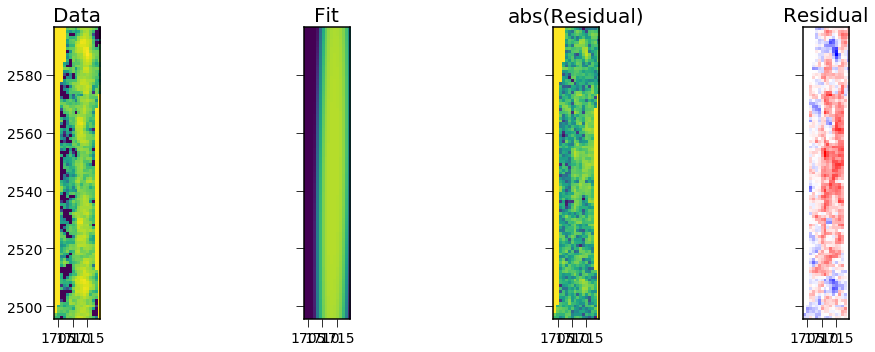

In [33]:
plot_fit_results()

In [34]:
#plot_fit_results2()

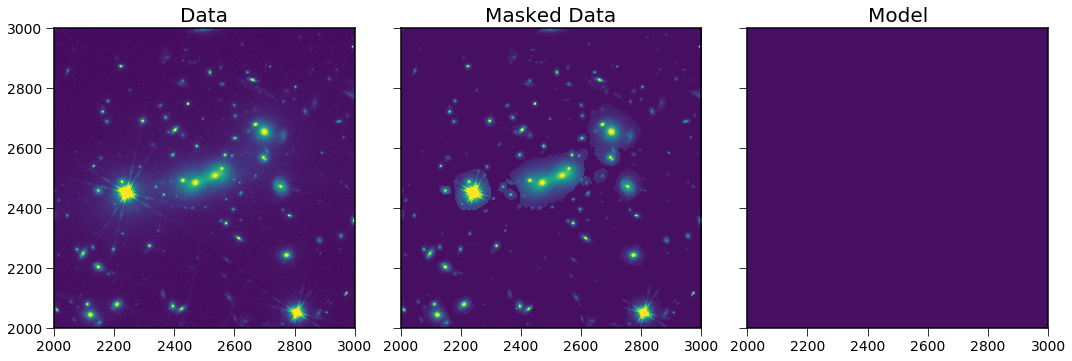

In [35]:
show_fit()

In [36]:
#plot_fit_results('plots/fit_results.png')

In [37]:
s = '               id     amplitude          r     ellip   theta    n      x         y'
print(s)

fout = open('MACS0647_Sersic_fits.cat', 'w')
fout.write(s+'\n')

fout_messages = open('MACS0647_Sersic_fit_messages.txt', 'w')

data_counts_initial = data_count_rate * exposure_time  # re-initialize
image = data_counts_initial * 0

ids = tbl['id']

for itbl, segm_id in enumerate(ids):
    data_counts = data_counts_initial - image
    fit_object_to_Sersic(segm_id)
    
    s = '%4d  ' % segm_id
    model_values = model.amplitude.value, model.r_eff.value, model.ellip.value, model.theta.value, model.n.value, model.x_0.value, model.y_0.value
    #s += '%8.3f % 10.3f  %5.2f  %5.2f  %4.2f  %5.1f  %5.1f' % model_values
    s += '%11.4g  % 11.4g  %6.3f  %6.3f  %4.2f  %7.3f  %7.3f' % model_values
    print('%4d / %4d  ' % (itbl, len(tbl)), s)
    fout.write(s+'\n')
    
    stamp, extent = Sersic_galaxy(model, floor=1e-7)  # should probably multiply floor by exposure time...
    image = add_stamp_to_image(image, stamp, extent)
    
    sid = '%4d / %4d   %4d  ' % (itbl+1, len(tbl), segm_id)
    sm = sid + fitter.fit_info['message']
    print(sm)
    fout_messages.write(sm+'\n')
    
    #plot_file = 'plots/image_%04d_%d.png' % (itbl, segm_id)
    #show_fit(plot_file)

    plot_file = 'plots/fit_%04d_%d.png' % (itbl, segm_id)
    plot_fit_results(plot_file)
    #wait = input()

               id     amplitude          r     ellip   theta    n      x         y


/Users/dcoe/miniconda3/envs/astroconda3p/lib/python3.7/site-packages/astropy/modeling/functional_models.py:2488: RuntimeWarning: divide by zero encountered in true_divide
  z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)
/Users/dcoe/miniconda3/envs/astroconda3p/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


   0 / 1198     16    1.215e+07        3.112   0.039  -1.159  0.41  2347.859  1674.198
   1 / 1198     16  The relative error between two consecutive iterates is at most 0.000000
   1 / 1198    431    4.169e+06        2.024   0.035   1.404  0.72  2240.915  2449.973
   2 / 1198    431  The relative error between two consecutive iterates is at most 0.000000
   2 / 1198    183    1.759e+06            2   0.000  -0.418  0.86  2806.736  2051.726
   3 / 1198    183  The relative error between two consecutive iterates is at most 0.000000
   3 / 1198      5     1.75e+06        1.759   0.000  -0.322  0.64  2436.405  1431.065
   4 / 1198      5  The relative error between two consecutive iterates is at most 0.000000
   4 / 1198    576    6.105e+05         1.84   0.046  -0.491  0.58  3405.950  2405.584
   5 / 1198    576  The relative error between two consecutive iterates is at most 0.000000
   5 / 1198    286         1164        31.33   0.158   0.268  1.89  2469.406  2483.242
   6 / 1198    286

  46 / 1198   1418         1651         10.8   0.396  -0.940  0.73  3097.678  3627.850
  47 / 1198   1418  The relative error between two consecutive iterates is at most 0.000000
  47 / 1198    471         1537        9.993   0.355   1.045  1.30  2096.297  2247.904
  48 / 1198    471  The relative error between two consecutive iterates is at most 0.000000
  48 / 1198    990         7267        3.908   0.030  -1.368  0.74  3351.719  2949.033
  49 / 1198    990  The relative error between two consecutive iterates is at most 0.000000
  49 / 1198    637        76.26         65.5   0.059   1.451  1.83  2761.936  2637.649
  50 / 1198    637  The relative error between two consecutive iterates is at most 0.000000
  50 / 1198   1032         6742        3.407   0.112  -0.377  0.83  1908.980  2984.423
  51 / 1198   1032  The relative error between two consecutive iterates is at most 0.000000
  51 / 1198    557         4185        4.236   0.133  -1.313  1.04  1899.872  2330.596
  52 / 1198    557

  92 / 1198    133        911.8        7.282   0.224   1.221  1.26  3021.499  1714.825
  93 / 1198    133  The relative error between two consecutive iterates is at most 0.000000
  93 / 1198     61         1736         6.62   0.368   1.478  0.71  2766.122  1509.255
  94 / 1198     61  The relative error between two consecutive iterates is at most 0.000000
  94 / 1198   1515        666.6           14   0.171  -1.383  2.14  2568.305  2575.224
  95 / 1198   1515  The relative error between two consecutive iterates is at most 0.000000
  95 / 1198    618         5416          4.4   0.535  -0.250  0.49  2781.659  2373.904
  96 / 1198    618  The relative error between two consecutive iterates is at most 0.000000
  96 / 1198    703    1.344e+04        1.785   0.063  -1.089  0.64  3081.209  2503.860
  97 / 1198    703  The relative error between two consecutive iterates is at most 0.000000
  97 / 1198    874         1769        5.276   0.182  -1.056  0.97  3095.288  2751.760
  98 / 1198    874

 138 / 1198   1326         2085        3.077   0.150   1.057  0.84  1848.891  3370.403
 139 / 1198   1326  The relative error between two consecutive iterates is at most 0.000000
 139 / 1198   1045         1685        3.533   0.225  -0.580  0.75  2444.056  3031.273
 140 / 1198   1045  The relative error between two consecutive iterates is at most 0.000000
 140 / 1198    563         1738        3.448   0.101   0.169  0.80  3173.206  2266.198
 141 / 1198    563  The relative error between two consecutive iterates is at most 0.000000
 141 / 1198     17        591.1        7.822   0.312   0.863  0.83  2313.769  1330.093
 142 / 1198     17  The relative error between two consecutive iterates is at most 0.000000
 142 / 1198   1426         5036         2.02   0.043  -0.744  0.92  3137.390  3558.724
 143 / 1198   1426  The relative error between two consecutive iterates is at most 0.000000
 143 / 1198    865         1152        5.797   0.477   0.191  0.85  2946.700  2686.466
 144 / 1198    865

 184 / 1198    386        248.1         10.2   0.462  -0.981  1.03  2581.843  2101.503
 185 / 1198    386  The relative error between two consecutive iterates is at most 0.000000
 185 / 1198   1144          102         15.9   0.295  -0.169  1.50  2656.365  3077.803
 186 / 1198   1144  The relative error between two consecutive iterates is at most 0.000000
 186 / 1198    851        55.21        27.27   0.440   1.349  1.43  2865.602  2747.461
 187 / 1198    851  The relative error between two consecutive iterates is at most 0.000000
 187 / 1198    764         1037        4.159   0.242   1.395  0.77  1625.341  2556.882
 188 / 1198    764  The relative error between two consecutive iterates is at most 0.000000
 188 / 1198   1507        274.9            9   0.065  -0.901  2.19  2203.397  2411.646
 189 / 1198   1507  The relative error between two consecutive iterates is at most 0.000000
 189 / 1198   1480          687        6.875   0.499  -0.138  0.85  2163.386  1762.955
 190 / 1198   1480

 230 / 1198    334        60.83         18.5   0.223   0.265  1.51  2635.153  2022.539
 231 / 1198    334  The relative error between two consecutive iterates is at most 0.000000
 231 / 1198   1542        283.5          8.5   0.025  -1.020  0.95  2646.517  2654.843
 232 / 1198   1542  The relative error between two consecutive iterates is at most 0.000000
 232 / 1198    965        182.8        6.956   0.000   0.140  0.95  1748.041  2839.490
 233 / 1198    965  The relative error between two consecutive iterates is at most 0.000000
 233 / 1198    171        112.9           12   0.000   0.475  1.41  1720.715  1776.343
 234 / 1198    171  The relative error between two consecutive iterates is at most 0.000000
 234 / 1198   1303        201.2        8.633   0.340   1.080  1.12  1421.477  3305.624
 235 / 1198   1303  The relative error between two consecutive iterates is at most 0.000000
 235 / 1198    408         2459        1.768   0.000  -0.809  0.71  2905.894  2052.270
 236 / 1198    408

 276 / 1198    892          300         5.18   0.272   1.320  0.76  1965.636  2753.122
 277 / 1198    892  The relative error between two consecutive iterates is at most 0.000000
 277 / 1198   1266        241.6         10.3   0.740   0.033  0.69  2934.418  3214.662
 278 / 1198   1266  The relative error between two consecutive iterates is at most 0.000000
 278 / 1198   1506        77.37           62   0.956   1.559  0.25  1713.669  2546.230
 279 / 1198   1506  The relative error between two consecutive iterates is at most 0.000000
 279 / 1198    853        288.4        6.065   0.165  -0.322  1.03  2380.639  2650.469
 280 / 1198    853  The relative error between two consecutive iterates is at most 0.000000
 280 / 1198   1489        150.3        9.439   0.429   1.544  1.01  2540.003  1973.233
 281 / 1198   1489  The relative error between two consecutive iterates is at most 0.000000
 281 / 1198    450        167.2        7.672   0.198  -1.372  0.79  3772.765  2123.812
 282 / 1198    450

 322 / 1198   1512        211.7        7.353   0.000  -0.457  1.18  2408.039  2438.129
 323 / 1198   1512  The relative error between two consecutive iterates is at most 0.000000
 323 / 1198    904          374        3.822   0.122   1.555  0.91  2762.490  2752.432
 324 / 1198    904  The relative error between two consecutive iterates is at most 0.000000
 324 / 1198   1226          191        5.114   0.224   0.566  0.91  1968.640  3172.947
 325 / 1198   1226  The relative error between two consecutive iterates is at most 0.000000
 325 / 1198    905        449.2        3.171   0.018  -0.352  0.80  1923.405  2731.812
 326 / 1198    905  The relative error between two consecutive iterates is at most 0.000000
 326 / 1198    498        208.7        4.877   0.062   0.389  1.04  3749.414  2172.661
 327 / 1198    498  The relative error between two consecutive iterates is at most 0.000000
 327 / 1198   1529         1013         2.14   0.000  -0.459  0.77  2502.657  2401.732
 328 / 1198   1529

 368 / 1198     31        354.4        3.834   0.269   0.487  0.59  2225.373  1303.773
 369 / 1198     31  The relative error between two consecutive iterates is at most 0.000000
 369 / 1198     77        271.8        4.836   0.324   1.071  0.67  2527.591  1500.215
 370 / 1198     77  The relative error between two consecutive iterates is at most 0.000000
 370 / 1198   1243        41.57         17.5   0.679  -0.389  0.93  2301.093  3201.108
 371 / 1198   1243  The relative error between two consecutive iterates is at most 0.000000
 371 / 1198    247        359.5        3.302   0.181  -1.302  0.74  1848.799  1823.232
 372 / 1198    247  The relative error between two consecutive iterates is at most 0.000000
 372 / 1198   1414        69.62        9.617   0.472  -0.358  0.98  2389.556  3515.877
 373 / 1198   1414  The relative error between two consecutive iterates is at most 0.000000
 373 / 1198    580        354.1        2.955   0.019   1.486  0.70  3112.927  2267.149
 374 / 1198    580

 414 / 1198   1107        227.2          5.5   0.132  -0.206  1.09  1255.519  3005.655
 415 / 1198   1107  The relative error between two consecutive iterates is at most 0.000000
 415 / 1198    206          301          3.4   0.230   0.809  0.87  3385.550  1735.460
 416 / 1198    206  The relative error between two consecutive iterates is at most 0.000000
 416 / 1198   1176        46.65         14.5   0.607  -0.545  1.46  3239.219  3089.478
 417 / 1198   1176  The relative error between two consecutive iterates is at most 0.000000
 417 / 1198   1256        195.6        4.111   0.259  -1.146  0.77  2184.075  3207.700
 418 / 1198   1256  The relative error between two consecutive iterates is at most 0.000000
 418 / 1198   1044        314.9        3.792   0.375  -0.943  0.71  1251.627  2901.820
 419 / 1198   1044  The relative error between two consecutive iterates is at most 0.000000
 419 / 1198   1547        85.56            7   0.410  -0.861  1.07  2796.043  2459.965
 420 / 1198   1547

 460 / 1198    186        48.91        6.776   0.263   1.548  1.15  1964.584  1718.106
 461 / 1198    186  The relative error between two consecutive iterates is at most 0.000000
 461 / 1198    609        224.8        3.612   0.103  -0.009  0.74  1780.037  2283.244
 462 / 1198    609  The relative error between two consecutive iterates is at most 0.000000
 462 / 1198    997        137.3        3.807   0.026   0.342  0.78  1859.114  2829.685
 463 / 1198    997  The relative error between two consecutive iterates is at most 0.000000
 463 / 1198   1028         87.7        6.219   0.295   1.465  0.79  2207.763  2897.770
 464 / 1198   1028  The relative error between two consecutive iterates is at most 0.000000
 464 / 1198      7        74.22          9.5   0.482   0.355  0.91  2296.561  1166.978
 465 / 1198      7  The relative error between two consecutive iterates is at most 0.000000
 465 / 1198   1514        527.1        1.452   0.025   0.951  0.44  2527.781  2453.899
 466 / 1198   1514

 506 / 1198     44        257.5            4   0.275  -0.016  0.89  2348.642  1339.887
 507 / 1198     44  The relative error between two consecutive iterates is at most 0.000000
 507 / 1198    714        24.98        17.75   0.326   0.408  1.47  3035.758  2474.477
 508 / 1198    714  The relative error between two consecutive iterates is at most 0.000000
 508 / 1198   1541         86.8          7.5   0.056   0.852  0.75  2639.452  2717.070
 509 / 1198   1541  The relative error between two consecutive iterates is at most 0.000000
 509 / 1198   1443        240.3        3.099   0.324  -0.624  0.54  2831.371  3611.960
 510 / 1198   1443  The relative error between two consecutive iterates is at most 0.000000
 510 / 1198   1100        78.49          6.5   0.325  -0.748  1.09  2881.949  2974.441
 511 / 1198   1100  The relative error between two consecutive iterates is at most 0.000000
 511 / 1198    111        105.1        4.764   0.122   1.097  0.86  1863.430  1573.788
 512 / 1198    111

 552 / 1198   1026        65.83        6.061   0.310   0.169  1.21  2449.536  2882.415
 553 / 1198   1026  The relative error between two consecutive iterates is at most 0.000000
 553 / 1198   1329        107.8        4.064   0.284  -1.045  0.77  2856.506  3326.095
 554 / 1198   1329  The relative error between two consecutive iterates is at most 0.000000
 554 / 1198    234         97.7            6   0.245   0.725  0.86  1679.079  1784.580
 555 / 1198    234  The relative error between two consecutive iterates is at most 0.000000
 555 / 1198   1549        76.37        4.021   0.076  -0.130  0.60  2731.113  2425.230
 556 / 1198   1549  The relative error between two consecutive iterates is at most 0.000000
 556 / 1198   1251         46.7          9.5   0.553  -1.335  0.95  2238.945  3205.780
 557 / 1198   1251  The relative error between two consecutive iterates is at most 0.000000
 557 / 1198    816        58.28          5.5   0.069  -0.548  1.26  2794.116  2592.200
 558 / 1198    816

 598 / 1198    354        75.39            6   0.378   1.116  0.90  2234.398  1969.742
 599 / 1198    354  The relative error between two consecutive iterates is at most 0.000000
 599 / 1198   1343        55.78            5   0.401   0.950  0.89  1395.975  3340.828
 600 / 1198   1343  The relative error between two consecutive iterates is at most 0.000000
 600 / 1198     13        170.5        3.043   0.226  -0.903  0.63  2218.988  1217.878
 601 / 1198     13  The relative error between two consecutive iterates is at most 0.000000
 601 / 1198   1389        123.9        3.217   0.214   1.327  0.56  2366.996  3432.020
 602 / 1198   1389  The relative error between two consecutive iterates is at most 0.000000
 602 / 1198    640        95.36          7.5   0.398   1.522  0.86  2349.618  2340.852
 603 / 1198    640  The relative error between two consecutive iterates is at most 0.000000
 603 / 1198   1371        75.56          5.5   0.402  -1.119  0.95  2693.166  3387.095
 604 / 1198   1371

 644 / 1198    648        39.09            7   0.000  -1.413  0.79  1910.572  2357.498
 645 / 1198    648  The relative error between two consecutive iterates is at most 0.000000
 645 / 1198   1205        60.93          6.5   0.385   0.443  0.54  1734.475  3121.318
 646 / 1198   1205  The relative error between two consecutive iterates is at most 0.000000
 646 / 1198    252        57.46            8   0.376   0.017  0.58  2475.101  1820.274
 647 / 1198    252  The relative error between two consecutive iterates is at most 0.000000
 647 / 1198    422        68.88          5.5   0.193  -0.019  0.89  2090.435  2110.186
 648 / 1198    422  The relative error between two consecutive iterates is at most 0.000000
 648 / 1198    758        71.16        4.693   0.000   1.557  0.91  1684.861  2512.285
 649 / 1198    758  The relative error between two consecutive iterates is at most 0.000000
 649 / 1198   1039        79.83         3.91   0.172   0.255  0.62  2478.499  2886.979
 650 / 1198   1039

 690 / 1198   1180        105.9        2.575   0.171  -1.292  0.61  1927.773  3073.626
 691 / 1198   1180  The relative error between two consecutive iterates is at most 0.000000
 691 / 1198   1054        43.95        4.886   0.000   0.023  1.16  2431.651  2904.448
 692 / 1198   1054  The relative error between two consecutive iterates is at most 0.000000
 692 / 1198    902        58.05            5   0.075  -1.498  0.89  2384.685  2712.092
 693 / 1198    902  The relative error between two consecutive iterates is at most 0.000000
 693 / 1198   1548        38.92          7.5   0.531  -1.163  0.92  1555.267  3050.937
 694 / 1198   1548  The relative error between two consecutive iterates is at most 0.000000
 694 / 1198    348        63.06            4   0.084   1.334  1.53  2986.476  1952.461
 695 / 1198    348  The relative error between two consecutive iterates is at most 0.000000
 695 / 1198   1504        50.02            5   0.000  -0.576  0.99  2591.815  2075.947
 696 / 1198   1504

 736 / 1198   1131        60.42          4.5   0.368   1.459  0.88  1774.835  3007.181
 737 / 1198   1131  The relative error between two consecutive iterates is at most 0.000000
 737 / 1198    510        58.59          4.5   0.117  -0.566  0.99  2199.518  2157.832
 738 / 1198    510  The relative error between two consecutive iterates is at most 0.000000
 738 / 1198   1240        43.34            6   0.463  -0.570  0.87  2840.213  3170.294
 739 / 1198   1240  The relative error between two consecutive iterates is at most 0.000000
 739 / 1198     62        69.43          4.5   0.459  -1.291  0.86  2675.936  1420.303
 740 / 1198     62  The relative error between two consecutive iterates is at most 0.000000
 740 / 1198   1065        39.76        3.202   0.335  -1.196  0.55  2367.142  2922.283
 741 / 1198   1065  The relative error between two consecutive iterates is at most 0.000000
 741 / 1198   1228        58.44          4.5   0.335  -0.060  0.72  2393.767  3143.547
 742 / 1198   1228

 782 / 1198    970       -213.5        3.291   0.000  -1.391  0.25  1838.000  2794.039
 783 / 1198    970  The relative error between two consecutive iterates is at most 0.000000
 783 / 1198     86        61.28          7.5   0.199  -0.329  0.62  2371.500  1496.570
 784 / 1198     86  The relative error between two consecutive iterates is at most 0.000000
 784 / 1198    600           53          3.5   0.104   0.631  1.19  2875.335  2261.324
 785 / 1198    600  The relative error between two consecutive iterates is at most 0.000000
 785 / 1198    438        11.58          6.5   0.042   0.080  1.29  1964.944  2083.249
 786 / 1198    438  The relative error between two consecutive iterates is at most 0.000000
 786 / 1198     67        67.47            5   0.197  -0.089  0.76  2352.127  1428.912
 787 / 1198     67  The relative error between two consecutive iterates is at most 0.000000
 787 / 1198    513        30.16          5.5   0.169   0.223  0.92  3271.560  2164.657
 788 / 1198    513

 828 / 1198    521        57.23          3.5   0.000  -0.747  0.69  2003.779  2174.889
 829 / 1198    521  The relative error between two consecutive iterates is at most 0.000000
 829 / 1198   1281        47.53            6   0.568   0.082  0.25  2341.323  3219.397
 830 / 1198   1281  The relative error between two consecutive iterates is at most 0.000000
 830 / 1198    555        21.41            6   0.539   0.224  0.88  3142.583  2209.439
 831 / 1198    555  The relative error between two consecutive iterates is at most 0.000000
 831 / 1198    591        54.44            4   0.364  -0.357  0.99  3613.472  2250.484
 832 / 1198    591  The relative error between two consecutive iterates is at most 0.000000
 832 / 1198    843        45.72            3   0.046  -0.425  2.35  1869.536  2609.477
 833 / 1198    843  The relative error between two consecutive iterates is at most 0.000000
 833 / 1198   1030         54.8           20   0.732   0.931  0.25  1684.367  2897.374
 834 / 1198   1030

 874 / 1198   1320        39.22            4   0.335   1.407  0.80  3052.329  3291.831
 875 / 1198   1320  The relative error between two consecutive iterates is at most 0.000000
 875 / 1198   1296        40.26            4   0.361  -1.094  0.91  3082.642  3248.366
 876 / 1198   1296  The relative error between two consecutive iterates is at most 0.000000
 876 / 1198    769        52.38            4   0.352  -1.558  0.86  3246.946  2524.206
 877 / 1198    769  The relative error between two consecutive iterates is at most 0.000000
 877 / 1198   1175        38.53            4   0.165   0.301  1.12  1600.385  3053.216
 878 / 1198   1175  The relative error between two consecutive iterates is at most 0.000000
 878 / 1198    528        55.42          3.5   0.422   0.112  0.73  3129.756  2182.512
 879 / 1198    528  The relative error between two consecutive iterates is at most 0.000000
 879 / 1198    862        49.37          4.5   0.498   1.066  0.80  3341.051  2642.056
 880 / 1198    862

 920 / 1198    108        56.14            3   0.086   0.311  0.69  1962.587  1544.822
 921 / 1198    108  The relative error between two consecutive iterates is at most 0.000000
 921 / 1198   1152        44.92          3.5   0.206  -0.633  0.53  1534.788  3028.841
 922 / 1198   1152  Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
 922 / 1198    349        51.99          3.5   0.155  -0.841  0.55  1795.017  1950.459
 923 / 1198    349  The relative error between two consecutive iterates is at most 0.000000
 923 / 1198   1208           50            4   0.507  -0.322  0.25  3230.852  3105.883
 924 / 1198   1208  The relative error between two consecutive iterates is at most 0.000000
 924 / 1198    589        43.88            4   0.006   1.159  0.25  3113.234  2253.290
 925 / 1198    589  The relative error between two consecutive iterates is at most 0.000000
 925 / 1198   1115        31.47          3.5   0.000  -1.226  0.99  3039.059  2978.294

 966 / 1198   1139        47.86          2.5   0.060   1.025  1.17  2303.564  3012.953
 967 / 1198   1139  The relative error between two consecutive iterates is at most 0.000000
 967 / 1198    951         60.7          2.5   0.000  -0.627  0.45  2953.590  2764.117
 968 / 1198    951  The relative error between two consecutive iterates is at most 0.000000
 968 / 1198   1075         55.3            3   0.426  -1.424  0.56  3261.915  2918.214
 969 / 1198   1075  The relative error between two consecutive iterates is at most 0.000000
 969 / 1198   1439        54.56          2.5   0.144  -0.886  0.49  2307.191  3582.605
 970 / 1198   1439  The relative error between two consecutive iterates is at most 0.000000
 970 / 1198    702         69.1          3.5   0.084  -0.982  0.25  2664.030  2419.877
 971 / 1198    702  The relative error between two consecutive iterates is at most 0.000000
 971 / 1198   1456        52.92          2.5   0.250  -0.088  0.76  2535.460  3662.866
 972 / 1198   1456

1012 / 1198    724        67.79            3   0.270  -1.554  0.58  1685.509  2449.408
1013 / 1198    724  The relative error between two consecutive iterates is at most 0.000000
1013 / 1198    778        68.07          2.5   0.096  -0.676  0.25  1827.841  2527.892
1014 / 1198    778  Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
1014 / 1198    310        40.83          3.5   0.158  -1.086  0.25  3167.907  1906.093
1015 / 1198    310  The relative error between two consecutive iterates is at most 0.000000
1015 / 1198   1377        30.42            3   0.185  -0.090  1.04  2561.709  3385.901
1016 / 1198   1377  The relative error between two consecutive iterates is at most 0.000000
1016 / 1198   1441        64.06          2.5   0.517   0.381  0.40  2450.668  3586.291
1017 / 1198   1441  The relative error between two consecutive iterates is at most 0.000000
1017 / 1198    565        108.2            2   0.100   1.205  0.28  2182.737  2217.869

1058 / 1198    323        71.82            2   0.125  -0.291  0.27  1783.255  1915.375
1059 / 1198    323  The relative error between two consecutive iterates is at most 0.000000
1059 / 1198   1409        7.139         11.5   0.620  -1.525  1.37  2411.829  3474.070
1060 / 1198   1409  The relative error between two consecutive iterates is at most 0.000000
1060 / 1198   1229         43.6          2.5   0.200  -1.556  0.48  2928.457  3137.511
1061 / 1198   1229  The relative error between two consecutive iterates is at most 0.000000
1061 / 1198   1348        27.99            4   0.580  -1.424  0.65  3046.566  3347.135
1062 / 1198   1348  The relative error between two consecutive iterates is at most 0.000000
1062 / 1198    566        74.57            2   0.208  -0.489  0.65  2348.009  2217.482
1063 / 1198    566  The relative error between two consecutive iterates is at most 0.000000
1063 / 1198    991        21.51          3.5   0.518  -0.257  0.57  2416.748  2798.000
1064 / 1198    991

/Users/dcoe/miniconda3/envs/astroconda3p/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/dcoe/miniconda3/envs/astroconda3p/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/Users/dcoe/miniconda3/envs/astroconda3p/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/dcoe/miniconda3/envs/astroconda3p/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/dcoe/miniconda3/envs/astroconda3p/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/dcoe/miniconda3/envs/astroconda3p/lib/python3.7/

1065 / 1198   1212        26.97          3.5   0.000  -0.876  0.68  2545.886  3123.019
1066 / 1198   1212  The relative error between two consecutive iterates is at most 0.000000
1066 / 1198   1282        10.39          2.5   0.111  -0.522  1.35  2278.495  3219.006
1067 / 1198   1282  The relative error between two consecutive iterates is at most 0.000000
1067 / 1198     66        46.54          2.5   0.183   0.320  0.55  2086.629  1414.287
1068 / 1198     66  The relative error between two consecutive iterates is at most 0.000000
1068 / 1198    683        64.12          2.5   0.382  -0.890  0.50  2974.964  2385.392
1069 / 1198    683  The relative error between two consecutive iterates is at most 0.000000
1069 / 1198    819        62.35            2   0.268  -0.600  0.44  1743.458  2574.881
1070 / 1198    819  The relative error between two consecutive iterates is at most 0.000000
1070 / 1198   1091        47.34            3   0.460   1.385  0.32  1855.713  2940.860
1071 / 1198   1091

1110 / 1198   1209        38.22          3.5   0.437   0.410  0.26  3005.489  3109.595
1111 / 1198   1209  The relative error between two consecutive iterates is at most 0.000000
1111 / 1198    824        21.59            2   0.000   0.506  0.84  3002.278  2580.101
1112 / 1198    824  The relative error between two consecutive iterates is at most 0.000000
1112 / 1198     82        65.89            2   0.000   0.193  0.83  2117.761  1480.154
1113 / 1198     82  The relative error between two consecutive iterates is at most 0.000000
1113 / 1198    397         37.5          2.5   0.265  -1.370  0.71  3364.053  2006.131
1114 / 1198    397  The relative error between two consecutive iterates is at most 0.000000
1114 / 1198    508        61.49          2.5   0.311  -0.240  0.25  2552.248  2143.205
1115 / 1198    508  The relative error between two consecutive iterates is at most 0.000000
1115 / 1198   1288        37.78          2.5   0.000  -1.200  0.25  2195.662  3224.981
1116 / 1198   1288

1156 / 1198    391        49.46          1.5   0.083   0.825  0.28  3354.086  1993.542
1157 / 1198    391  The relative error between two consecutive iterates is at most 0.000000
1157 / 1198   1001         47.7          1.5   0.000   1.206  0.25  2132.229  2811.638
1158 / 1198   1001  The relative error between two consecutive iterates is at most 0.000000
1158 / 1198    271        55.62          1.5   0.089  -0.681  0.25  3072.431  1837.384
1159 / 1198    271  The relative error between two consecutive iterates is at most 0.000000
1159 / 1198   1368        25.03            2   0.355  -0.757  0.71  2614.902  3366.744
1160 / 1198   1368  The relative error between two consecutive iterates is at most 0.000000
1160 / 1198    296        43.03            2   0.000   0.684  0.25  3350.796  1886.193
1161 / 1198    296  The relative error between two consecutive iterates is at most 0.000000
1161 / 1198    525        48.44          1.5   0.042  -0.641  0.41  3358.072  2170.620
1162 / 1198    525

TypeError: Improper input: N=4 must not exceed M=2

In [38]:
hdu_model = fits.open(image_file)[0]
hdu_model.data = image
hdu_model.writeto('MACS0647_Sersic.fits', overwrite=True)